<a href="https://colab.research.google.com/github/snoop2head/OIA_Text_Wrangling/blob/master/_Department_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
print(pd.__version__)
print(np.__version__)

1.1.0
1.18.5


In [2]:
file_name = "department_data.csv"
path = "data_wrangled/" + file_name
df = pd.read_csv(path)
# 데이터의 크기가 어느정도인지 본다.
print(df.shape)
df.sample(5)

(469, 5)


,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR
387,US000183,Union College,4,2,1.000000
462,US000290,University of Groningen,9,9,0.000000
350,US000119,Nebraska Wesleyan University,8,4,3.000000
214,MX000009,Universidad de Monterrey (UDEM),4,3,0.222222
312,US000056,Creighton University,3,3,0.000000


In [3]:
df_data = df.loc[df["NUM_VISITS"]>=6]
df_data.sample(5)

,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR
148,GB000025,University of Westminster,7,7,0.000000
342,US000105,Mercer University,8,8,0.000000
173,IT000008,Luiss Guido Carli,20,11,3.966942
118,FR000006,Pole ESG-Paris Graduate School of Management,27,15,1.226667
183,JP000008,International Christian University,19,14,0.658163


In [4]:
columns_dropping = ["대학코드", "대학명"]
data = df_data.drop(columns=columns_dropping)
data[:5]

,NUM_VISITS,NUM_DEP,VAR
1,40,10,25.600000
3,7,7,0.000000
4,46,15,27.795556
5,13,4,6.187500
6,11,9,0.172840


In [5]:
columns_df = list(df.columns)
columns_data = [column for column in columns_df if column not in columns_dropping]
columns_data

['NUM_VISITS', 'NUM_DEP', 'VAR']

In [6]:
# 정규화
transformer = MinMaxScaler(feature_range=(0, 1))
transformer.fit(data)
x_data = transformer.transform(data)

In [7]:
pd.DataFrame(x_data, columns=columns_data).corr()

,NUM_VISITS,NUM_DEP,VAR
NUM_VISITS,1.000000,0.915019,0.555216
NUM_DEP,0.915019,1.000000,0.328120
VAR,0.555216,0.328120,1.000000


### Variance, Num_visit, Num_dep 갖고 산출한 cluster
종합대, 단과대 라벨이 없기 때문에 비지도학습 기법인 Kmeans Clustering을 진행함.

- 0번 그룹: 전공의 편향도가 높은 그룹, 학생수가 어느 정도 있음
- 1번 그룹: 전공의 편향도가 낮은 그룹, 학생수가 매우 많음
- 2번 그룹: 전공의 편향도가 높은 그룹, 그리고 학생이 적음
- 3번 그룹: 전공의 편향도가 낮고, 학생수가 많음

In [8]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

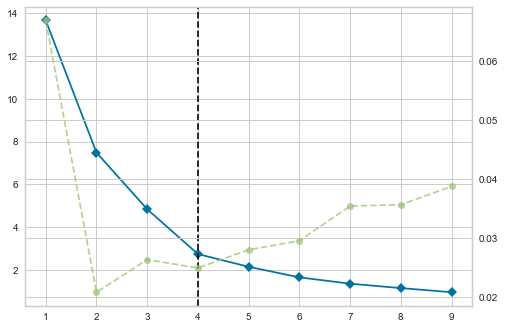

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(x_data)

In [10]:
# 4개 군집으로 진행
no_clusters = 4
model = KMeans(n_clusters=no_clusters, random_state=307)
model.fit(x_data)

KMeans(n_clusters=4, random_state=307)

In [11]:
cluster_mean = pd.DataFrame(model.cluster_centers_, columns=columns_data)
cluster_mean

,NUM_VISITS,NUM_DEP,VAR
0,0.145507,0.274379,0.043783
1,0.718387,0.670438,0.417782
2,0.027614,0.080750,0.017778
3,0.104137,0.092603,0.393517


In [12]:
df_data['category'] = model.labels_

In [13]:
df_data['category'].value_counts()

2    199
0     73
3     17
1      7
Name: category, dtype: int64

In [14]:
df_data[df_data['category'] == 3]

,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR,category
38,CA000013,University of Manitoba,47,10,54.810000,3
45,CA000020,York University: Schulich School of Business,36,6,57.333333,3
74,DE000002,European Business School,40,11,40.413223,3
75,DE000003,Freie Universitat Berlin,51,14,62.658163,3
92,ES000001,ESADE,24,5,57.760000,3
112,FI000014,Aalto University,73,15,88.915556,3
114,FR000002,KEDGE Business School,46,14,47.489796,3
169,IT000001,Bocconi University,60,17,49.425606,3
216,NL000001,"Erasmus University, Rotterdam",61,16,47.277344,3
221,NL000006,Saxion University,33,8,68.359375,3


In [15]:
print("단과대일 수도 있습니다. 본인 전공 수업이 열리는지 잘 확인하세요" , list(df_data[df_data['category'] == 3]["대학코드"].values))

단과대일 수도 있습니다. 본인 전공 수업이 열리는지 잘 확인하세요 ['CA000013', 'CA000020', 'DE000002', 'DE000003', 'ES000001', 'FI000014', 'FR000002', 'IT000001', 'NL000001', 'NL000006', 'NL000010', 'RU000002', 'RU000003', 'SE000001', 'SG000003', 'US000046', 'US000123']


In [16]:
pca = PCA(n_components=2)
pca_fit = pca.fit(x_data)

In [17]:
pca_result = pd.DataFrame(data=pca.fit_transform(x_data))

In [18]:
pca_result['category'] = model.labels_

In [19]:
pca_result[:5]

,0,1,category
0,-0.004694,0.104660,2
1,-0.131490,0.000542,2
2,0.041696,0.091612,2
3,-0.127949,0.042853,2
4,-0.112039,-0.008487,2


In [20]:
pca_result = pca_result.rename(columns={0:'pca1', 1:'pca2'})

In [21]:
# randomly assign colors to the dot
import random
color_lists = []
for i in range(no_clusters):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    color_code = "#" + color
    color_lists.append(color_code)
color_lists

['#31ad43', '#aac4b1', '#b72663', '#9d9993']

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

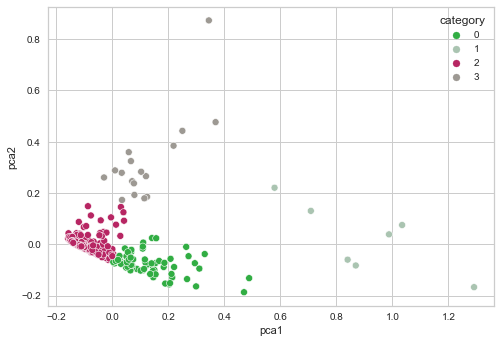

In [22]:
import seaborn as sns
sns.scatterplot(data=pca_result, x='pca1', y='pca2', hue='category', palette=color_lists)